In [1]:
import os
import matplotlib.pyplot as plt
import cv2

import pandas as pd

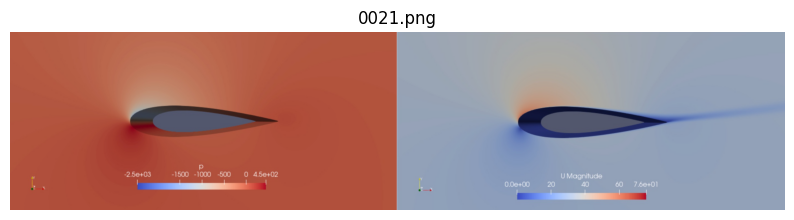

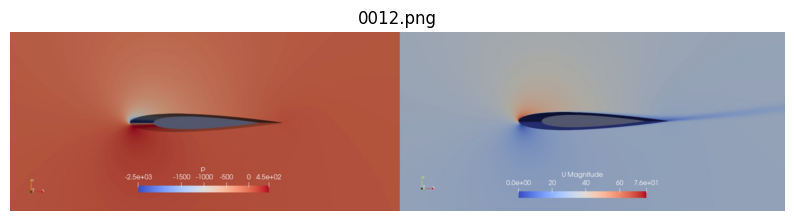

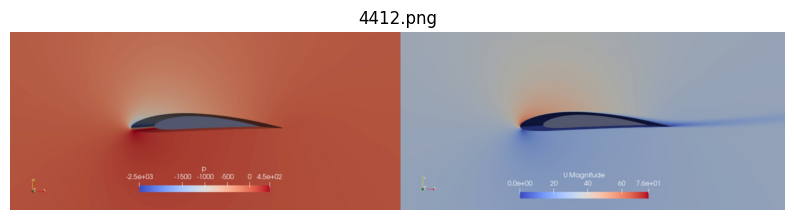

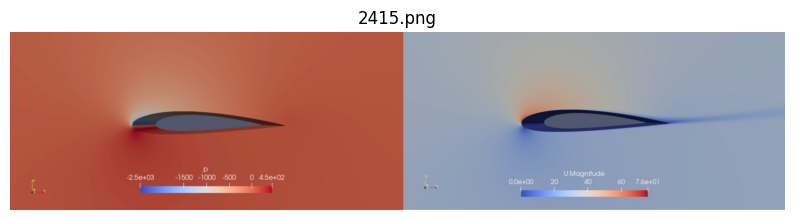

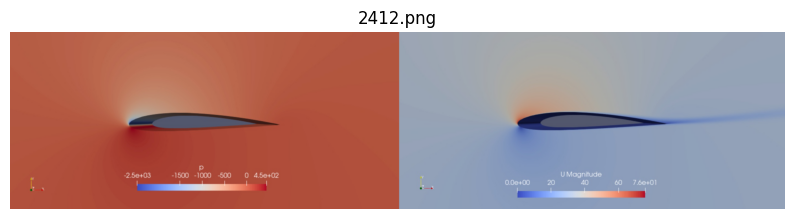

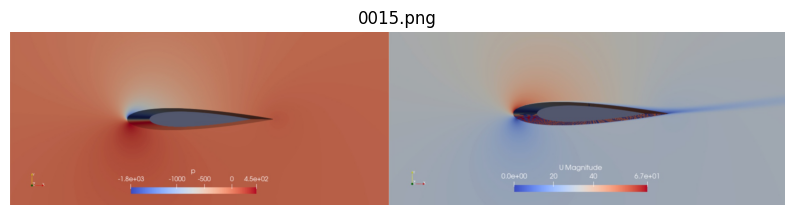

In [2]:
folder_path = "/kaggle/input/ae646-gp1-data"

png_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]

for file in png_files:
    img_path = os.path.join(folder_path, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.title(file)
    plt.axis("off")  
    plt.show()


In [3]:
from IPython.display import Image
from IPython.display import clear_output
import os

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.interpolate import griddata

In [4]:
def plot_covariance_heatmap(covariance_matrix):
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(covariance_matrix, cmap='coolwarm', interpolation='nearest')
    for i in range(covariance_matrix.shape[0]):
        for j in range(covariance_matrix.shape[1]):
            plt.text(j, i, f'{covariance_matrix[i, j]:.2f}',
                     ha='center', va='center', color='black', fontsize=10)
    plt.title('Covariance Matrix Heatmap')
    plt.colorbar(heatmap)
    plt.xticks(np.arange(4), ['p', 'U0', 'U1', 'U2'], rotation=45)
    plt.yticks(np.arange(4), ['p', 'U0', 'U1', 'U2'])
    plt.show()

class FieldVisualizer:
    def __init__(self, data, method_name=""):
        self.data = data
        self.filtered_data = None
        self.fig = None
        self.axs = None
        self.method_name = method_name

    def filter_data(self, x_range, y_range):
        self.filtered_data = self.data[
            (self.data['Points:0'] >= x_range[0]) &
            (self.data['Points:0'] <= x_range[1]) &
            (self.data['Points:1'] >= y_range[0]) &
            (self.data['Points:1'] <= y_range[1])
        ]

    def plot_scatter(self, ax, x_data, y_data, c_data, cmap_label):
        scatter = ax.scatter(x_data, y_data, c=c_data, cmap='viridis', marker='o', s=5)
        cbar = self.fig.colorbar(scatter, ax=ax, label=cmap_label)

    def visualize(self):
        self.fig, self.axs = plt.subplots(2, 2, figsize=(12, 10))
        x_data = self.filtered_data['Points:0']
        y_data = self.filtered_data['Points:1']

        self.plot_scatter(self.axs[0, 0], x_data, y_data, self.filtered_data['U:0'], 'U0')
        self.plot_scatter(self.axs[0, 1], x_data, y_data, self.filtered_data['U:1'], 'U1')
        self.plot_scatter(self.axs[1, 0], x_data, y_data, self.filtered_data['U:2'], 'U2')
        self.plot_scatter(self.axs[1, 1], x_data, y_data, self.filtered_data['p'], 'Pressure')

        titles = [f'{self.method_name} U0 vs (Point 0, Point 1)', 
                  f'{self.method_name} U1 vs (Point 0, Point 1)',
                  f'{self.method_name} U2 vs (Point 0, Point 1)', 
                  f'{self.method_name} Pressure vs (Point 0, Point 1)']
        for i in range(2):
            for j in range(2):
                self.axs[i, j].set_xlabel('Point 0')
                self.axs[i, j].set_ylabel('Point 1')
                self.axs[i, j].set_title(titles[i * 2 + j])

        plt.tight_layout()
        plt.show()

class FlowFieldStreamlines:
    def __init__(self, data, method_name=""):
        self.data = data
        self.filtered_data = data
        self.method_name = method_name

    def filter_data(self, x_range, y_range):
        self.filtered_data = self.data[
            (self.data['Points:0'] >= x_range[0]) &
            (self.data['Points:0'] <= x_range[1]) &
            (self.data['Points:1'] >= y_range[0]) &
            (self.data['Points:1'] <= y_range[1])
        ]

    def generate_streamlines(self, x_range, y_range, num_streamlines=15):
        self.filter_data(x_range, y_range)
        x = self.filtered_data['Points:0']
        y = self.filtered_data['Points:1']
        u = self.filtered_data['U:0']
        v = self.filtered_data['U:1']

        xi = np.linspace(x_range[0], x_range[1], 100)
        yi = np.linspace(y_range[0], y_range[1], 100)
        xi, yi = np.meshgrid(xi, yi)

        ui = griddata((x, y), u, (xi, yi), method='linear')    
        vi = griddata((x, y), v, (xi, yi), method='linear')

        plt.figure(figsize=(10, 6))
        plt.streamplot(xi, yi, ui, vi, color='k', density=1.5, linewidth=1)
        plt.scatter(x, y, color='red', s=1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'{self.method_name} Flow Field Streamlines')
        plt.xlim(x_range)
        plt.ylim(y_range)
        plt.grid()
        plt.show()

class PCA:
    def __init__(self, data, retention=None, r=None):
        self.data = data
        self.data_np = data.values
        self.retention = retention
        self.r = r
        self.scaled_data = None
        self.covariance_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.selected_eigenvectors = None
        self.reduced_data = None
        self.reconstructed_data = None
        self.cumulative_variance = None
        self.num_components = None
        self.scaler = StandardScaler()
        self.method_name = "PCA"

    def standardize_data(self, relevants):
        self.scaled_data = self.scaler.fit_transform(relevants)

    def compute_covariance_matrix(self):
        self.covariance_matrix = np.cov(self.scaled_data, rowvar=False)
        plot_covariance_heatmap(self.covariance_matrix)

    def calculate_eigenvalues_eigenvectors(self):
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.covariance_matrix)
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]
        
    def plot_eigenvalues_plots(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.eigenvalues) + 1), self.eigenvalues, marker='o')
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Eigenvalue')
        plt.title(f'{self.method_name} Eigenvalues in Descending Order')
        plt.grid(True)
        plt.show()
        
        self.cumulative_variance = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.cumulative_variance) + 1), self.cumulative_variance, marker='o')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title(f'{self.method_name} Cumulative Explained Variance Plot')
        plt.grid(True)
        plt.show()
        
    def choose_r(self):
        if self.r is None:
            self.num_components = np.argmax(self.cumulative_variance >= self.retention) + 1
        else:
            self.num_components = self.r  
        
    def select_principal_components(self):
        self.choose_r()
        self.selected_eigenvectors = self.eigenvectors[:, :self.num_components]
        
    def project_data(self):
        self.reduced_data = np.dot(self.scaled_data, self.selected_eigenvectors)

    def inverse_transform(self):
        self.reconstructed_data = np.dot(self.reduced_data, self.selected_eigenvectors.T)
        self.reconstructed_data = self.scaler.inverse_transform(self.reconstructed_data)

    def combine_with_points(self, points):
        combined_data = np.concatenate((self.reconstructed_data, points), axis=1)
        column_names = ['p', 'U:0', 'U:1', 'U:2', 'Points:0', 'Points:1', 'Points:2']
        combined_df = pd.DataFrame(combined_data, columns=column_names)
        return combined_df

    def visualize(self, pd_data):
        vf_visualizer = FieldVisualizer(pd_data, self.method_name)
        vf_visualizer.filter_data(x_range=(-0.2, 1.2), y_range=(-0.5, 0.5))
        vf_visualizer.visualize()
        
        streamline_visualizer = FlowFieldStreamlines(pd_data, self.method_name)
        streamline_visualizer.generate_streamlines(x_range=(-0.2, 1.2), y_range=(-0.5, 0.5))
        
    def perform_PCA(self):
        self.visualize(self.data)
        relevants = self.data_np[:, 0:4]
        self.standardize_data(relevants)
        self.compute_covariance_matrix()
        self.calculate_eigenvalues_eigenvectors()
        # self.plot_eigenvalues_plots()
        self.select_principal_components()
        self.project_data()
        self.inverse_transform()
        points = self.data_np[:, 4:]
        recon_df = self.combine_with_points(points)
        self.visualize(recon_df)

class SVD:
    def __init__(self, data, retention=None, r=None):
        self.data = data
        self.data_np = data.values
        self.retention = retention
        self.r = r
        self.scaled_data = None
        self.singular_values = None
        self.left_singular_vectors = None
        self.selected_singular_vectors = None
        self.reduced_data = None
        self.reconstructed_data = None
        self.cumulative_variance = None
        self.num_components = None
        self.scaler = StandardScaler()
        self.method_name = "SVD"

    def standardize_data(self, relevants):
        self.scaled_data = self.scaler.fit_transform(relevants)

    def compute_svd(self):
        self.left_singular_vectors, self.singular_values, self.right_singular_vectors = np.linalg.svd(self.scaled_data, full_matrices=False)
        
    def plot_singular_values(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.singular_values) + 1), self.singular_values, marker='o', color='blue')
        plt.xlabel('Singular Value Index')
        plt.ylabel('Singular Value')
        plt.title(f'{self.method_name} Singular Values')
        plt.grid(True)
        plt.show()
        
        self.cumulative_variance = np.cumsum(self.singular_values ** 2) / np.sum(self.singular_values ** 2)
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.cumulative_variance) + 1), self.cumulative_variance, marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title(f'{self.method_name} Cumulative Explained Variance Plot')
        plt.grid(True)
        plt.show()
        
    def choose_r(self):
        if self.r is None:
            self.num_components = np.argmax(self.cumulative_variance >= self.retention) + 1
        else:
            self.num_components = self.r  
        
    def select_components(self):
        self.choose_r()
        self.selected_left_singular_vectors = self.left_singular_vectors[:, :self.num_components]
        self.selected_singular_values = self.singular_values[:self.num_components]
        self.selected_right_singular_vectors = self.right_singular_vectors[:self.num_components, :]

    def inverse_transform(self):
        self.reconstructed_data = self.selected_left_singular_vectors @ np.diag(self.selected_singular_values) @ self.selected_right_singular_vectors
        self.reconstructed_data = self.scaler.inverse_transform(self.reconstructed_data)

    def combine_with_points(self, points):
        combined_data = np.concatenate((self.reconstructed_data, points), axis=1)
        column_names = ['p', 'U:0', 'U:1', 'U:2', 'Points:0', 'Points:1', 'Points:2']
        combined_df = pd.DataFrame(combined_data, columns=column_names)
        return combined_df

    def visualize(self, pd_data):
        vf_visualizer = FieldVisualizer(pd_data, self.method_name)
        vf_visualizer.filter_data(x_range=(-0.2, 1.2), y_range=(-0.5, 0.5))
        vf_visualizer.visualize()
        
        streamline_visualizer = FlowFieldStreamlines(pd_data, self.method_name)
        streamline_visualizer.generate_streamlines(x_range=(-0.2, 1.2), y_range=(-0.5, 0.5))
        
    def perform_svd(self):
        self.visualize(self.data)
        relevants = self.data_np[:, 0:4]
        self.standardize_data(relevants)
        self.compute_svd()
        # self.plot_singular_values()
        self.select_components()
        self.inverse_transform()
        points = self.data_np[:, 4:]
        recon_df = self.combine_with_points(points)
        self.visualize(recon_df)

0012_3 Starting...


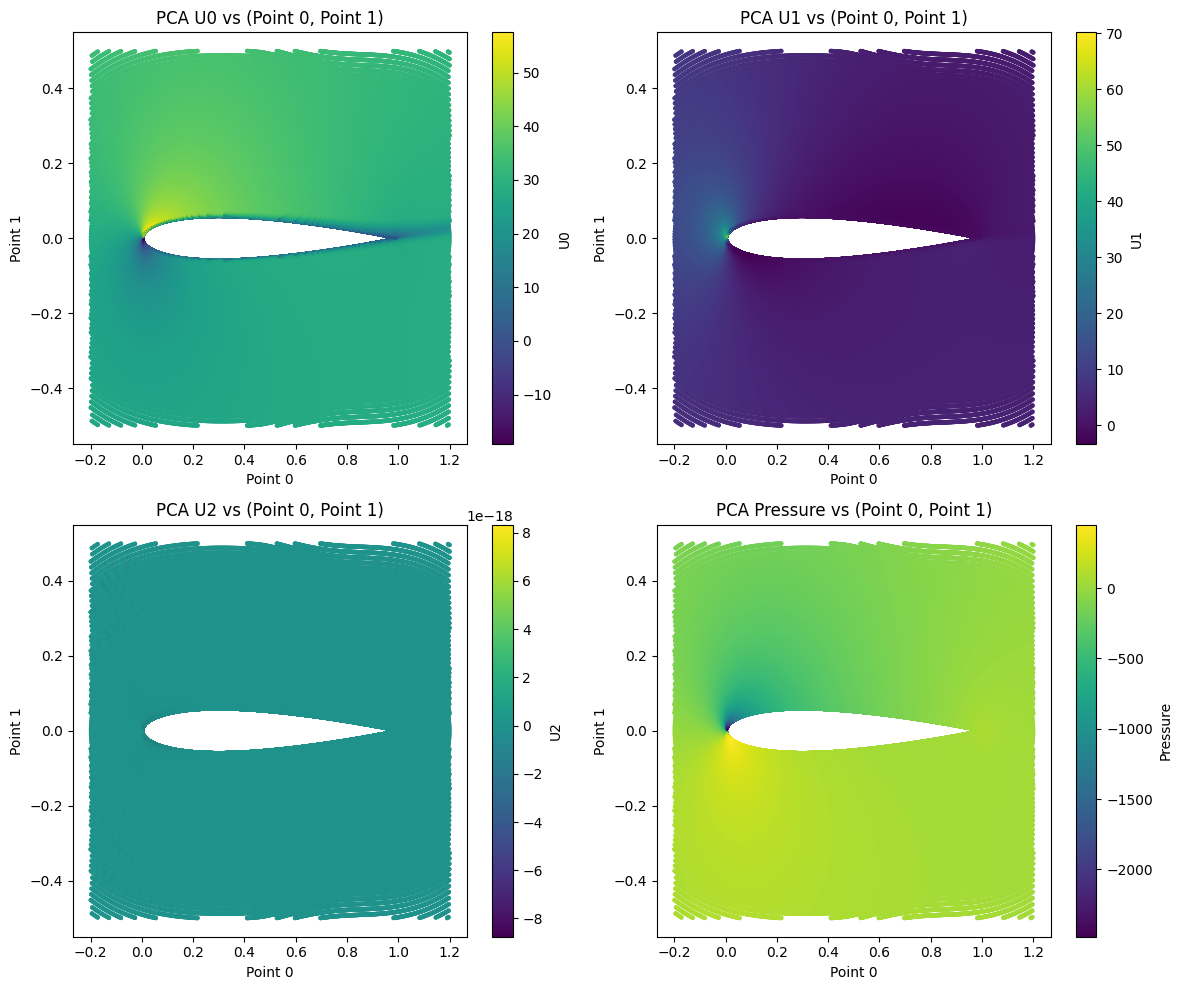

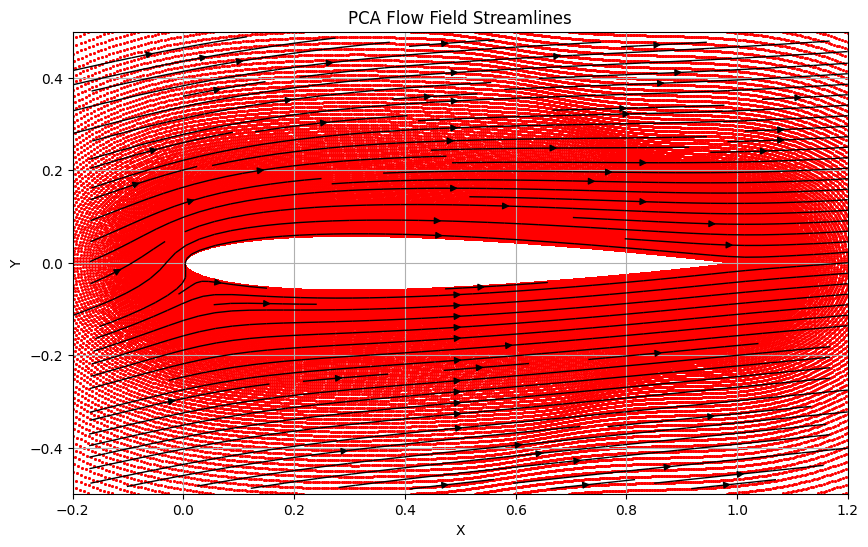

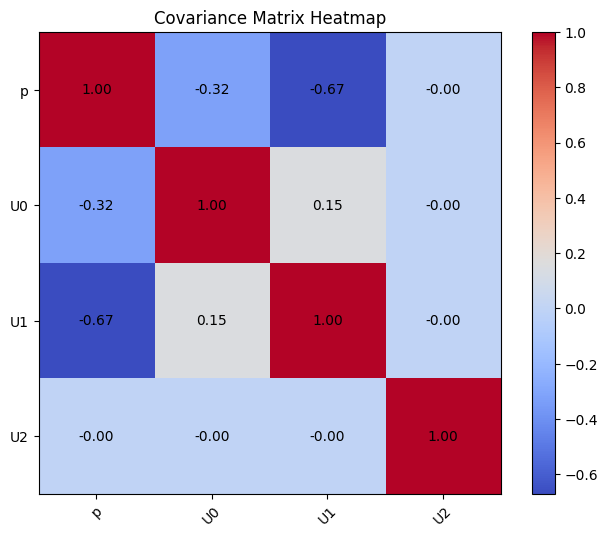

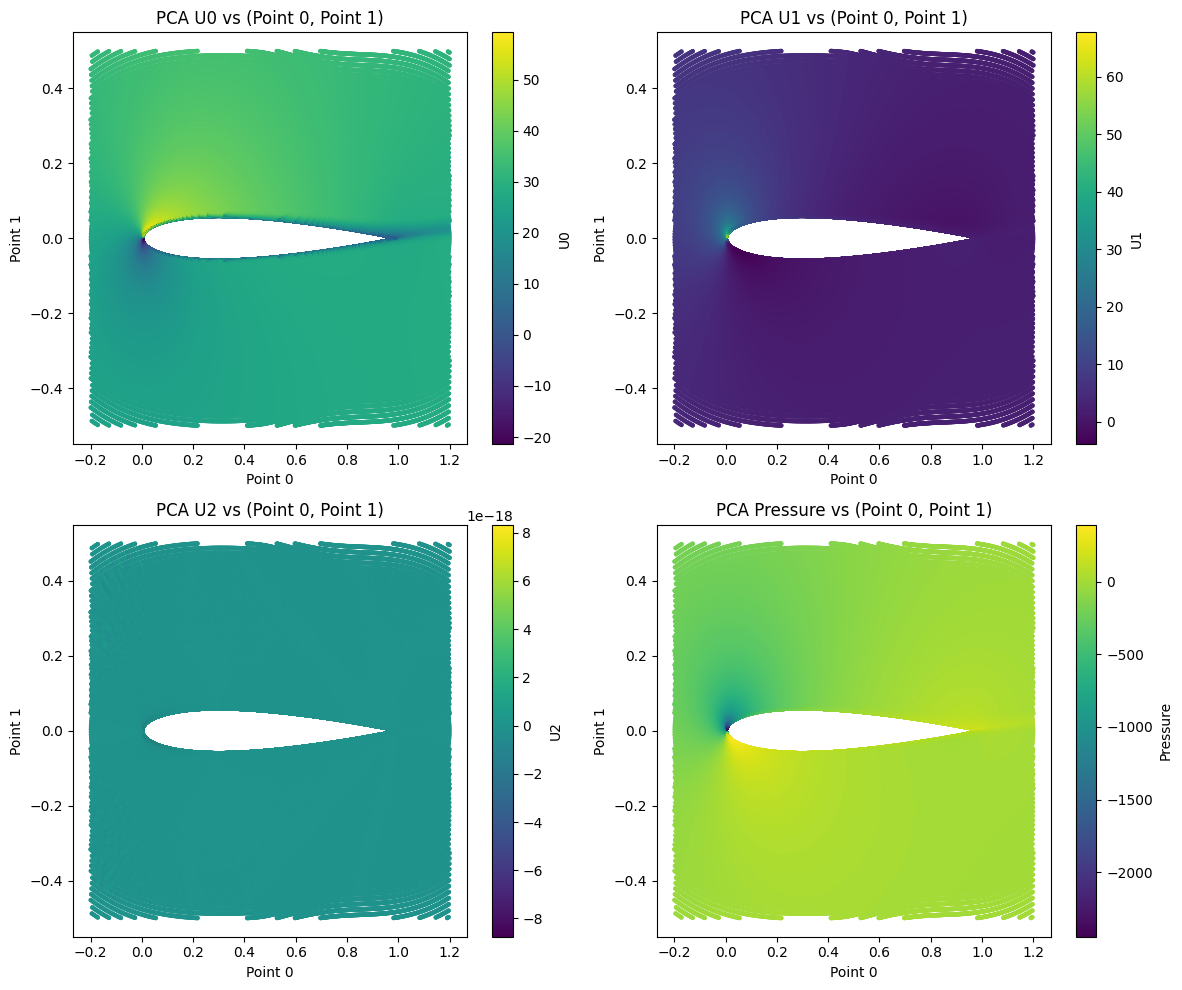

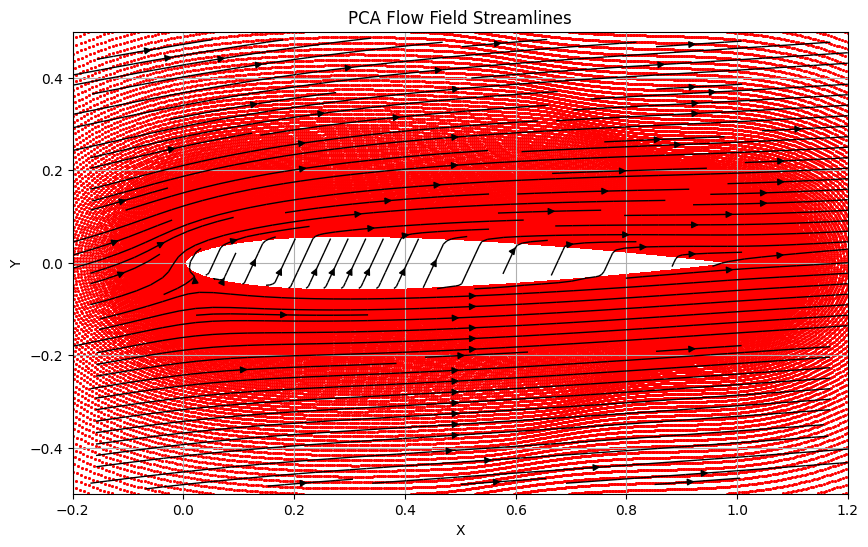

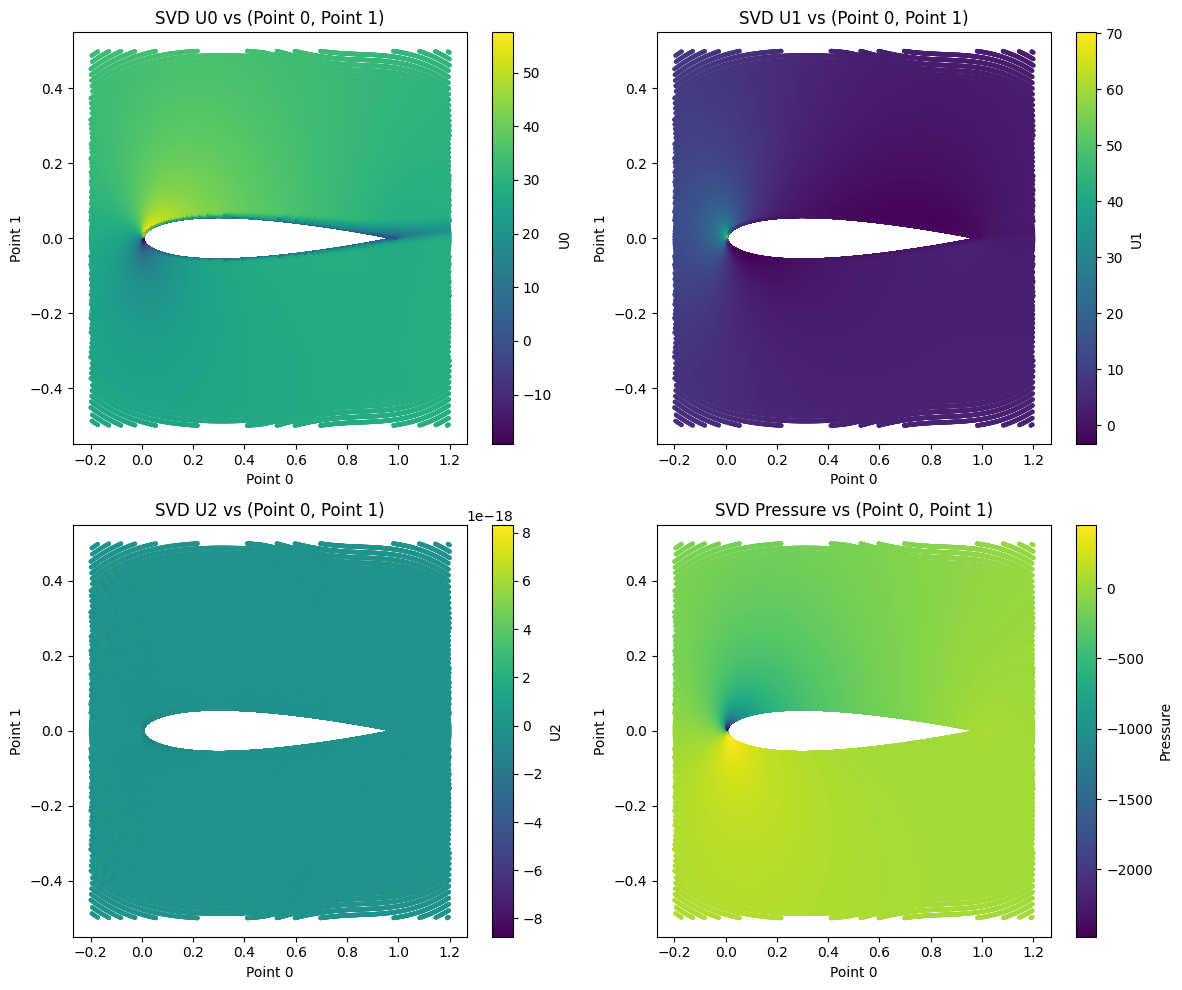

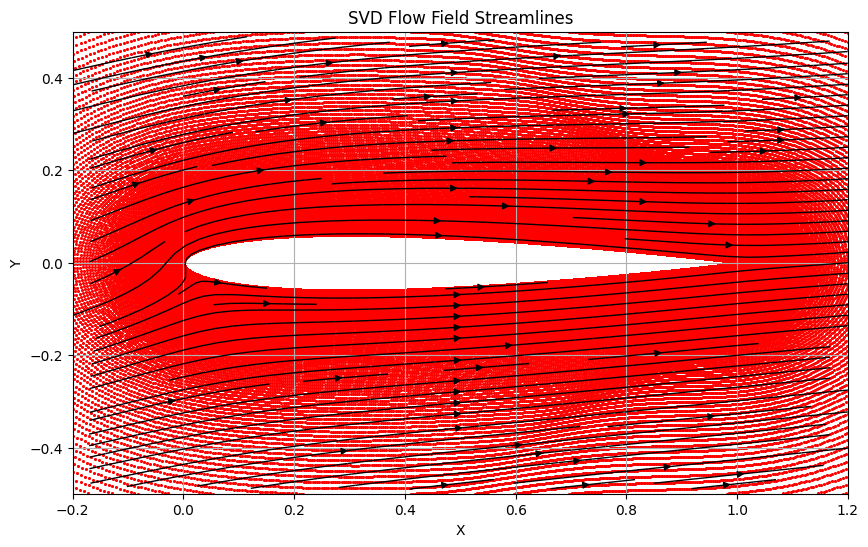

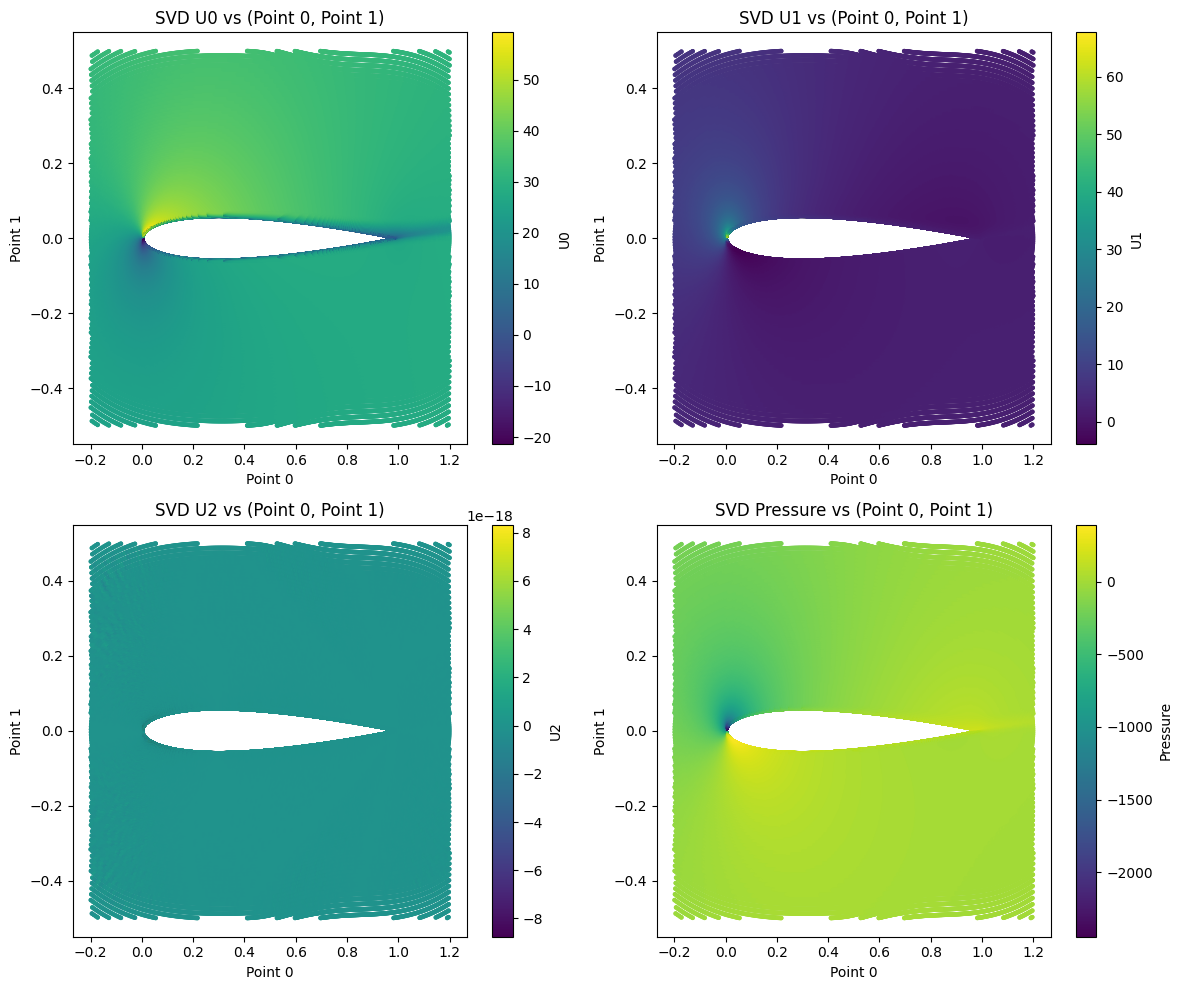

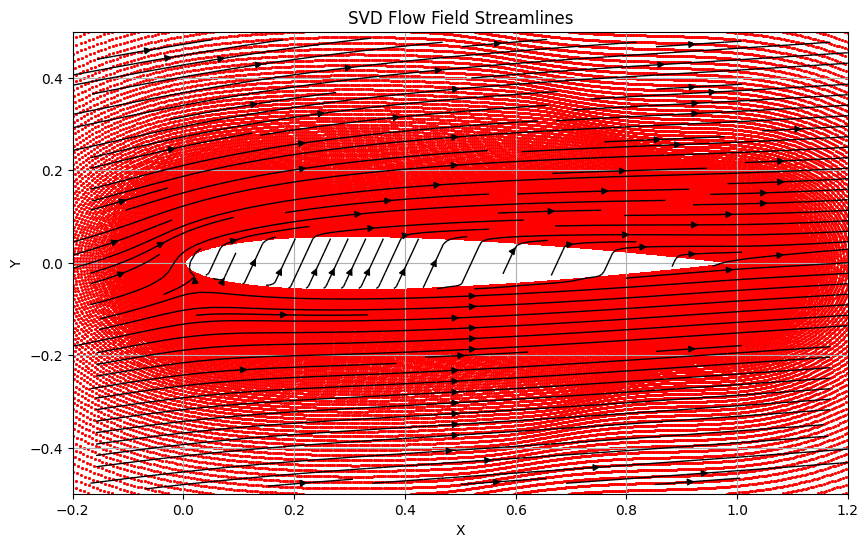

0012_3 Completed.


In [5]:
times = {}
# airfoils_to_use = ["0012", "0015", "0021", "2412", "2415", "4412"]
airfoils_to_use = ["0012"]

for airfoil_to_use in airfoils_to_use:
    for r in range(1, 4):
        clear_output(wait=True)
        print(f"{airfoil_to_use}_{r} Starting...")

        Image(f"/kaggle/input/ae646-gp1-data/{airfoil_to_use}.png")
        raw_data = pd.read_csv(f'/kaggle/input/ae646-gp1-data/{airfoil_to_use}.csv')

        start = time.time()
        pca_instance = PCA(raw_data, r=r)
        pca_instance.perform_PCA()
        end = time.time()
        times[f"{airfoil_to_use}_PCA_{r}"] = end - start

        start = time.time()
        svd_instance = SVD(raw_data, r=r)
        svd_instance.perform_svd()
        end = time.time()
        times[f"{airfoil_to_use}_SVD_{r}"] = end - start

        print(f"{airfoil_to_use}_{r} Completed.")